# Delayed Airliner Predictor

In [1]:
import os
import numpy as np
import pandas as pd
import pandas_profiling
from scipy import stats

from sklearn.metrics import classification_report, accuracy_score, f1_score, make_scorer
from sklearn.cross_validation  import train_test_split, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

import plotly, plotly.plotly as py, plotly.graph_objs as go
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


/home/hvyd/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/hvyd/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Import and Explore Data

In [9]:
df = pd.read_csv('data/ONTIME.csv')


In [5]:
df.describe()

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,AIRLINE_ID,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,DEST_AIRPORT_ID,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 39
count,467972.0,467972.0,467972.000000,467972.000000,467972.000000,467972.000000,467972.000000,4.679720e+05,467972.000000,467972.000000,...,467972.000000,463155.000000,462367.000000,467972.000000,70571.000000,70571.000000,70571.000000,70571.000000,70571.000000,0.0
mean,4.0,11.0,15.344177,3.941674,19923.742036,2153.624381,12674.258924,1.267429e+06,31704.017911,12674.070637,...,1488.438362,1475.670348,1.100784,820.248243,19.253022,2.649105,13.904493,0.123847,21.326820,NaN
std,0.0,0.0,8.677630,2.092900,386.359284,1741.844753,1528.525133,1.528522e+05,1278.448387,1528.643569,...,514.007281,526.183804,36.822443,603.353416,50.488775,22.211562,29.925576,3.512115,42.167602,NaN
min,4.0,11.0,1.000000,1.000000,19393.000000,1.000000,10135.000000,1.013503e+06,30070.000000,10135.000000,...,1.000000,1.000000,-80.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,4.0,11.0,8.000000,2.000000,19790.000000,726.000000,11292.000000,1.129202e+06,30647.000000,11292.000000,...,1108.000000,1058.000000,-15.000000,373.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,4.0,11.0,15.000000,4.000000,19805.000000,1718.000000,12889.000000,1.288903e+06,31453.000000,12889.000000,...,1517.000000,1512.000000,-6.000000,649.000000,2.000000,0.000000,2.000000,0.000000,0.000000,NaN
75%,4.0,11.0,23.000000,6.000000,20304.000000,3097.000000,13930.000000,1.393004e+06,32467.000000,13930.000000,...,1915.000000,1915.000000,5.000000,1061.000000,18.000000,0.000000,18.000000,0.000000,25.000000,NaN
max,4.0,11.0,30.000000,7.000000,21171.000000,7438.000000,16218.000000,1.621801e+06,35991.000000,16218.000000,...,2359.000000,2400.000000,1638.000000,4983.000000,1631.000000,1120.000000,798.000000,440.000000,983.000000,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467972 entries, 0 to 467971
Data columns (total 39 columns):
QUARTER                  467972 non-null int64
MONTH                    467972 non-null int64
DAY_OF_MONTH             467972 non-null int64
DAY_OF_WEEK              467972 non-null int64
FL_DATE                  467972 non-null object
UNIQUE_CARRIER           467972 non-null object
AIRLINE_ID               467972 non-null int64
CARRIER                  467972 non-null object
TAIL_NUM                 467440 non-null object
FL_NUM                   467972 non-null int64
ORIGIN_AIRPORT_ID        467972 non-null int64
ORIGIN_AIRPORT_SEQ_ID    467972 non-null int64
ORIGIN_CITY_MARKET_ID    467972 non-null int64
ORIGIN                   467972 non-null object
ORIGIN_CITY_NAME         467972 non-null object
ORIGIN_STATE_NM          467972 non-null object
DEST_AIRPORT_ID          467972 non-null int64
DEST_AIRPORT_SEQ_ID      467972 non-null int64
DEST_CITY_MARKET_ID      467972 non-

In [8]:
df.shape

(467972, 39)

In [9]:
profile = pandas_profiling.ProfileReport(df)
profile

Number of variables,39
Number of observations,467972
Total Missing (%),13.6%
Total size in memory,139.2 MiB
Average record size in memory,312.0 B
Numeric,20
Categorical,10
Boolean,0
Date,0
Text (Unique),0
Rejected,9


In [10]:
def clean_data(df, threshold, column):
    df_drop_missing = df.dropna(thresh=threshold, axis=1) 
    df_drop_missing.dropna(axis=0, inplace=True) 
    df_outlier = df_drop_missing[(np.abs(
        stats.zscore(df_drop_missing[column])) < 3).all(axis=1)] 
    return df_outlier

### Visualize Data

In [11]:
df_clean = clean_data(df, 300000, ['DEP_DELAY'])

/home/hvyd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



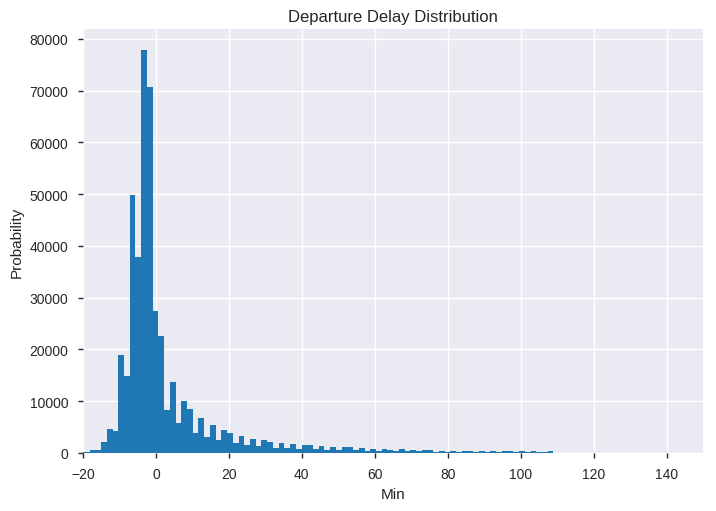

In [12]:
plt.hist(df_clean.DEP_DELAY, bins = 100)
plt.xlabel('Min')
plt.xlim(-20, 150)
plt.ylabel('Probability')
plt.title('Departure Delay Distribution')
plt.show()

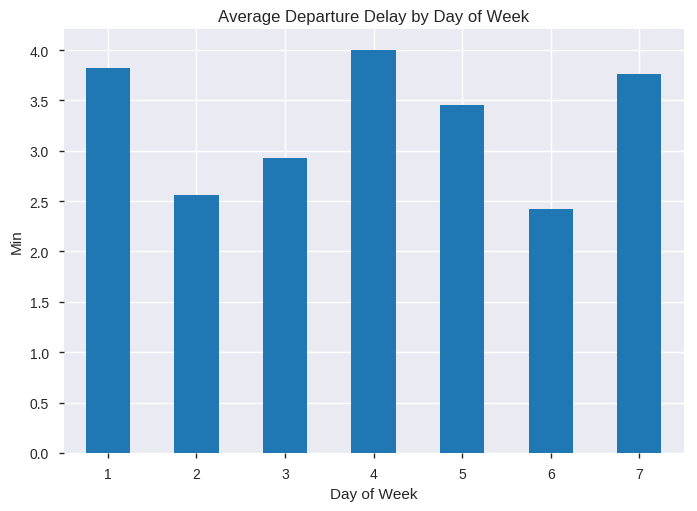

In [13]:
ax = df_clean[['DAY_OF_WEEK','DEP_DELAY']].groupby('DAY_OF_WEEK').mean().plot(kind='bar')
ax.legend_.remove()
plt.xticks(rotation=0)
plt.xlabel('Day of Week')
plt.ylabel('Min')
plt.title('Average Departure Delay by Day of Week')
plt.legend
plt.show()

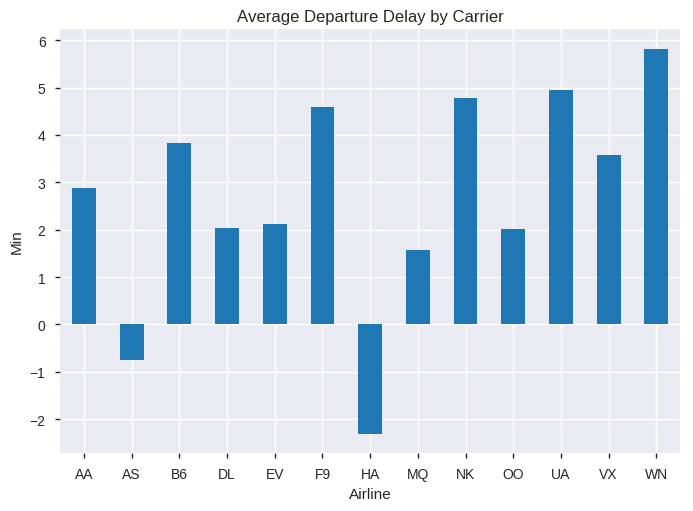

In [14]:
ax = df_clean[['UNIQUE_CARRIER','DEP_DELAY']].groupby('UNIQUE_CARRIER').mean().plot(kind='bar')
ax.legend_.remove()
plt.xticks(rotation=0)
plt.xlabel('Airline')
plt.ylabel('Min')
plt.title('Average Departure Delay by Carrier')
plt.legend
plt.show()

In [15]:
df_clean['DEP_HOUR'] = df_clean['CRS_DEP_TIME']//100

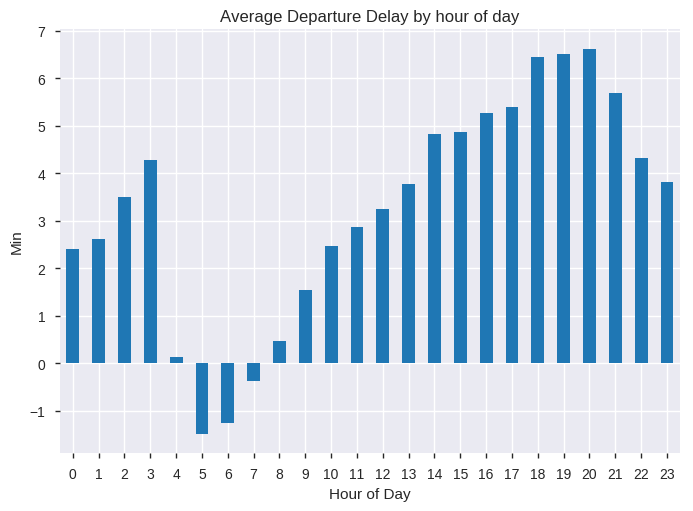

In [16]:
ax = df_clean[['DEP_HOUR','DEP_DELAY']].groupby('DEP_HOUR').mean().plot(kind='bar')
ax.legend_.remove()
plt.xticks(rotation=0)
plt.xlabel('Hour of Day')
plt.ylabel('Min')
plt.title('Average Departure Delay by hour of day')
plt.legend
plt.show()

### Prepare and Train Data

In [17]:
def binarize(df, col, new_col):
    for i, row in df.iterrows():
        if row[col]>0:
            df.set_value(i, new_col, 1)
        else:
            df.set_value(i, new_col, 0)
    return df

binarize(df_clean, 'DEP_DELAY', 'DELAYED')

/home/hvyd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead

/home/hvyd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,TAIL_NUM,FL_NUM,...,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,DISTANCE,DEP_HOUR,DELAYED
0,4,11,4,3,2015-11-04,AA,19805,AA,N3CHAA,86,...,25.0,816.0,1333.0,16.0,1352,1349.0,-3.0,1671.0,8,0.0
1,4,11,5,4,2015-11-05,AA,19805,AA,N3LTAA,87,...,20.0,1756.0,1949.0,3.0,2019,1952.0,-27.0,1739.0,17,0.0
2,4,11,6,5,2015-11-06,AA,19805,AA,N3MKAA,87,...,12.0,1802.0,2004.0,3.0,2019,2007.0,-12.0,1739.0,17,1.0
3,4,11,7,6,2015-11-07,AA,19805,AA,N3MJAA,87,...,10.0,1746.0,1945.0,4.0,2019,1949.0,-30.0,1739.0,17,0.0
4,4,11,8,7,2015-11-08,AA,19805,AA,N3MAAA,87,...,18.0,1758.0,1951.0,5.0,2019,1956.0,-23.0,1739.0,17,0.0
5,4,11,9,1,2015-11-09,AA,19805,AA,N3JVAA,87,...,22.0,1759.0,1953.0,5.0,2019,1958.0,-21.0,1739.0,17,0.0
6,4,11,10,2,2015-11-10,AA,19805,AA,N3LCAA,87,...,18.0,1758.0,1951.0,3.0,2019,1954.0,-25.0,1739.0,17,0.0
7,4,11,11,3,2015-11-11,AA,19805,AA,N3LYAA,87,...,20.0,1812.0,2015.0,4.0,2019,2019.0,0.0,1739.0,17,1.0
8,4,11,12,4,2015-11-12,AA,19805,AA,N3LFAA,87,...,15.0,1856.0,2110.0,4.0,2019,2114.0,55.0,1739.0,17,1.0
9,4,11,13,5,2015-11-13,AA,19805,AA,N3MDAA,87,...,14.0,1752.0,2003.0,4.0,2019,2007.0,-12.0,1739.0,17,0.0


In [18]:
df_features = df_clean[['ORIGIN_AIRPORT_ID', 'DEP_HOUR', 'DAY_OF_WEEK', 'AIRLINE_ID', 'DEST_AIRPORT_ID', 'TAXI_OUT', 'DISTANCE']]
X_train, X_test, y_train, y_test = train_test_split(df_features, df_clean.DELAYED, test_size=0.35)

In [19]:
param_grid = {"max_depth": [3, 8], "min_samples_leaf": [1, 10]}
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, scoring=make_scorer(f1_score)).fit(np.array(X_train), np.array(y_train))

print ('best params: ', grid_search.best_params_)

best params:  {'max_depth': 8, 'min_samples_leaf': 1}


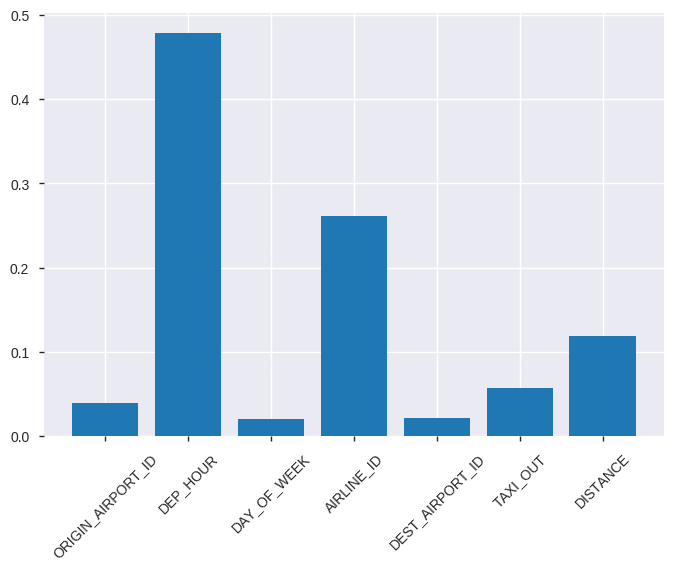

In [20]:
X = range(len(grid_search.best_estimator_.feature_importances_))
y = grid_search.best_estimator_.feature_importances_

plt.xticks(X, X_train.columns, rotation = 45)
plt.bar(X, y)
plt.show()

In [22]:
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        0.0       0.78      0.63      0.70    108921
        1.0       0.43      0.60      0.50     49896

avg / total       0.67      0.62      0.64    158817



In [23]:
print(accuracy_score(y_test, y_pred))

0.622993760114
